<a href="https://colab.research.google.com/github/electrodrago/computer-visit/blob/main/Dogs_and_cats_classification/dogs_and_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download the dataset**

In [ ]:
 ! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c dog-vs-cat-classification

 97% 694M/718M [00:03<00:00, 196MB/s]
100% 718M/718M [00:03<00:00, 225MB/s]


In [ ]:
! unzip dog-vs-cat-classification.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/train/dogs/dog.5499.jpg  
  inflating: train/train/dogs/dog.55.jpg  
  inflating: train/train/dogs/dog.550.jpg  
  inflating: train/train/dogs/dog.5500.jpg  
  inflating: train/train/dogs/dog.5501.jpg  
  inflating: train/train/dogs/dog.5502.jpg  
  inflating: train/train/dogs/dog.5503.jpg  
  inflating: train/train/dogs/dog.5504.jpg  
  inflating: train/train/dogs/dog.5505.jpg  
  inflating: train/train/dogs/dog.5506.jpg  
  inflating: train/train/dogs/dog.5507.jpg  
  inflating: train/train/dogs/dog.5508.jpg  
  inflating: train/train/dogs/dog.5509.jpg  
  inflating: train/train/dogs/dog.551.jpg  
  inflating: train/train/dogs/dog.5510.jpg  
  inflating: train/train/dogs/dog.5511.jpg  
  inflating: train/train/dogs/dog.5512.jpg  
  inflating: train/train/dogs/dog.5513.jpg  
  inflating: train/train/dogs/dog.5514.jpg  
  inflating: train/train/dogs/dog.5515.jpg  
  inflating: train/train/dogs/dog.5516.jpg  
  

# **GPU Test**

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Import the libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-fd27339f-ac9e-612a-243a-bec39a883e15)


In [ ]:
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG19

# **Image Preprocessing**

In [ ]:
train_path='/content/train/train' 
test_path='/content/test/test'

In [ ]:
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 224, 224, 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
BATCH_SIZE = 32

In [ ]:
train_gen = image_dataset_from_directory(train_path,
                                        label_mode = 'binary', 
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle = True,
                                        seed = 23,
                                        validation_split = 0.1,
                                        subset='training')
val_gen = image_dataset_from_directory(train_path,
                                        label_mode = 'binary', 
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle = True,
                                        seed = 23,
                                        validation_split = 0.1,
                                        subset='validation')

Found 25000 files belonging to 2 classes.
Using 22500 files for training.
Found 25000 files belonging to 2 classes.
Using 2500 files for validation.


# **Visualize the dataset**

In [ ]:
train_df = pd.DataFrame({'image_class':os.listdir(train_path)})
train_df

,image_class
0,dogs
1,cats


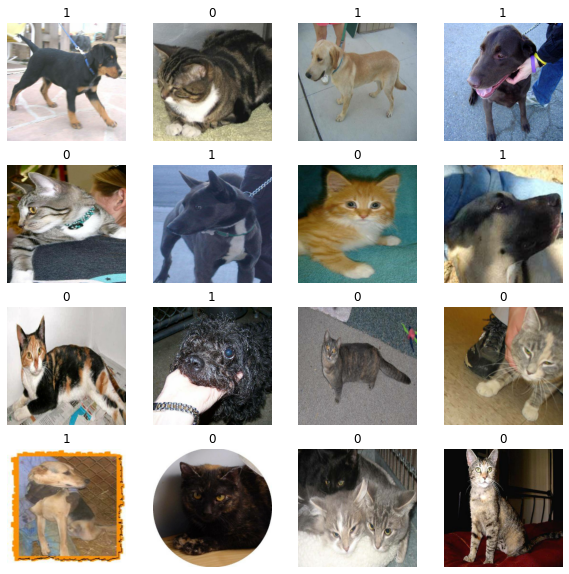

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_gen.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        ax.imshow(images[i].numpy().astype('uint8'))
        ax.set_title(int(labels[i]))
        ax.axis('off')
plt.show()

# **Data Augmentation**

When we don't have a large image dataset, I prefer to artifically introduce image diversity by adding some random yet realistic transformations to the training images. 

This helps expose our model to different aspects of the training data while minimising overfitting.

In [ ]:
data_augmentation = Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation((-0.1, 0.1)),
     layers.RandomZoom((-0.15, 0.15)),
     layers.RandomTranslation(0.05, 0.05)
    ]
)

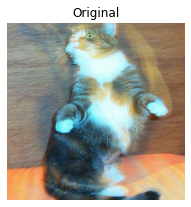

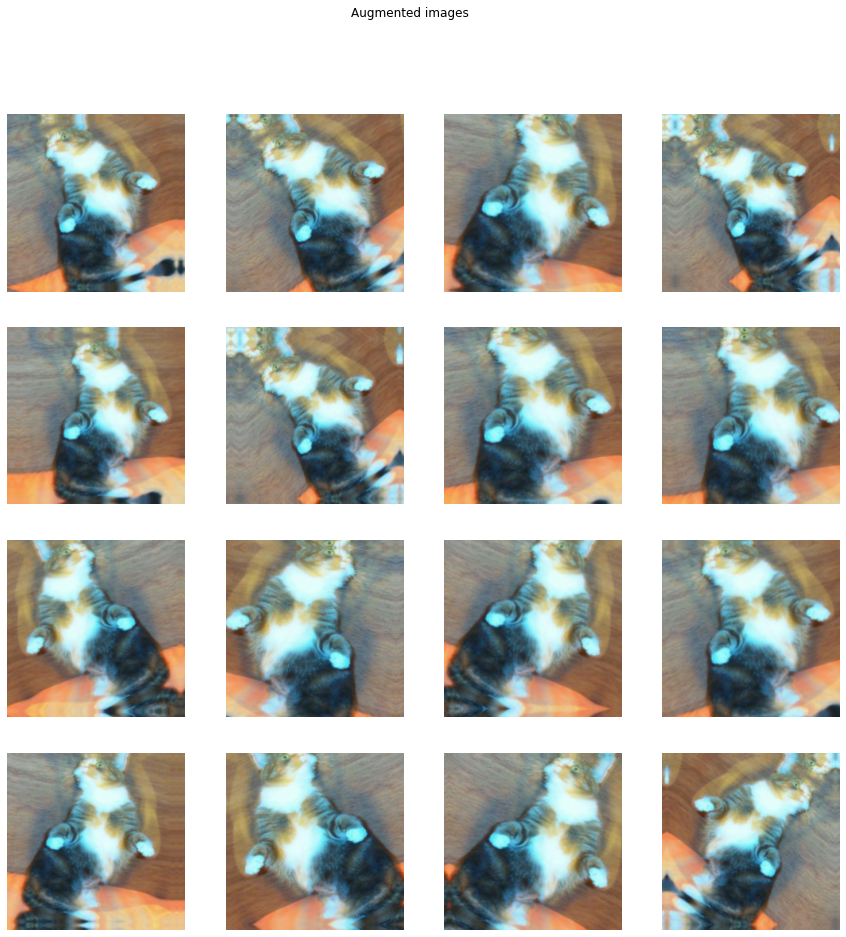

In [ ]:
plt.figure(figsize=(15, 15))
for images, _ in train_gen.take(1):
    ax = plt.subplot(441)
    ax.imshow(images[0].numpy().astype('uint8'))
    ax.set_title('Original')
    ax.axis('off')

    fig = plt.figure(figsize=(15, 15))
    for i in range(16):
        augmented_image = data_augmentation(images[0], training = True)
        ax = plt.subplot(4, 4, i+1)
        ax.imshow(augmented_image.numpy().astype('uint8'))
        ax.axis('off')
    fig.suptitle('Augmented images')
    plt.show()

# **Train the model**

[Strategy](https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy)

[How to choose loss function](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

In [ ]:
augmentation_layer = Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation((-0.1, 0.1)),
     layers.RandomZoom((-0.15, 0.15)),
     layers.RandomTranslation(0.05, 0.05),
     layers.Rescaling(1.0/255)
    ]
)
image_batch, label_batch = next(iter(train_gen))
feature_batch = augmentation_layer(image_batch)
print(feature_batch.shape)

(32, 224, 224, 3)


In [ ]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [ ]:
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = augmentation_layer(inputs)
x = preprocess_input(x)
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 32,870,465
Trainable params: 12,846,081
Non-trainable params: 20,024,384
_________________________________________________________________


# **Compile the model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 4

loss0, accuracy0 = model.evaluate(val_gen)

79/79 [==============================] - 29s 344ms/step - loss: 5.3044 - accuracy: 0.5192


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.30
initial accuracy: 0.52


In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_gen,
                    epochs = initial_epochs,
                    validation_data = val_gen)

Epoch 1/4
704/704 [==============================] - 270s 382ms/step - loss: 0.4072 - accuracy: 0.9560 - val_loss: 0.1194 - val_accuracy: 0.9664
Epoch 2/4
704/704 [==============================] - 270s 383ms/step - loss: 0.0285 - accuracy: 0.9911 - val_loss: 0.1409 - val_accuracy: 0.9708
Epoch 3/4
704/704 [==============================] - 270s 383ms/step - loss: 0.0071 - accuracy: 0.9978 - val_loss: 0.1930 - val_accuracy: 0.9636
Epoch 4/4
704/704 [==============================] - 270s 383ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.2774 - val_accuracy: 0.9596


# **Learning Curve**

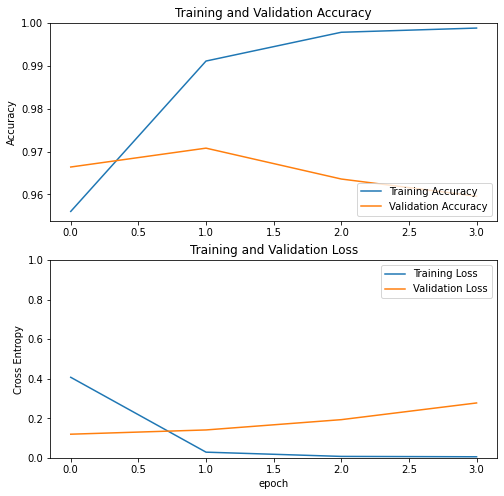

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import pickle
path = "/content/drive/Shared drives/DADN/Model/"
pickle.dump(model,open(path + 'modelMien.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://394dd8d3-b9da-4221-8b08-7427de3a1280/assets


In [ ]:
path = "/content/drive/Shared drives/DADN/Model/"
model = pickle.load(open(path + 'modelMien.pkl', 'rb'))

In [ ]:
model.save('mymodel.h5')

# **Predict**

In [ ]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(380, 380))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

In [ ]:
def predict(path: str):
	img = prepare(path)
	result = model.predict([img])
	result = result.tolist()[0]
	idx = result.index(max(result))
	lables = ['cats', 'dogs']
	print(lables[idx])
	print(max(result))

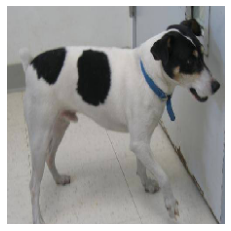

This image is 0.00 percent cat and 100.00 percent dog.


In [ ]:
img_num = str(np.random.randint(1, 12501))
sample_img = os.path.join('/content/test/test/000012.jpg')

img = keras.preprocessing.image.load_img(
    sample_img, target_size= IMG_SIZE
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img_array[0].numpy().astype('uint8'))
plt.axis('off')
plt.show()
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

# **Test dataset**

In [ ]:
test_ds = image_dataset_from_directory(
    test_path,
    label_mode=None,
    image_size=IMG_SIZE,
    shuffle=False
)

Found 8000 files belonging to 1 classes.


In [ ]:
test_filenames = [f.split('/')[-1] for f in test_ds.file_paths]

In [ ]:
vgg19_pred = model.predict(test_ds)

In [ ]:
pred_df = pd.DataFrame(
    { 'filename':test_filenames,
     'vgg19_score':vgg19_pred.reshape(1, -1)[0]
    }
)

pred_df['vgg19_prediction'] = (pred_df['vgg19_score'] >= 0.5).astype('int')

pred_df.head()

,filename,vgg19_score,vgg19_prediction
0,000000.jpg,9.999598e-01,1
1,000001.jpg,1.000000e+00,1
2,000002.jpg,1.000000e+00,1
3,000003.jpg,6.525636e-18,0
4,000004.jpg,1.000000e+00,1


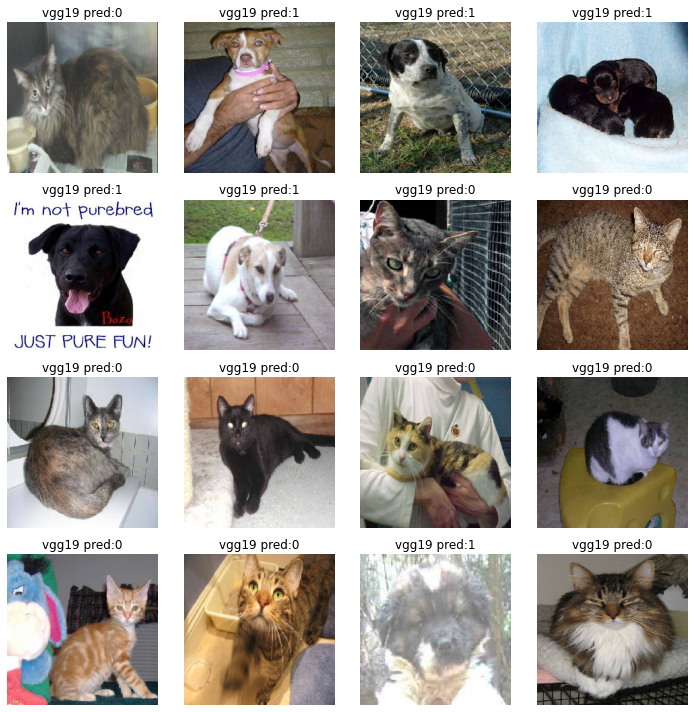

In [ ]:
n = 16

sample_img_df = pred_df.sample(n)
plt.figure(figsize=(10, 10))
for i in range(n):
    plt.subplot(4, 4, i+1)
    sample_img = os.path.join(test_path, sample_img_df.iloc[i].filename)
    img = image.load_img(
        sample_img, target_size = IMG_SIZE
    )
    plt.imshow(img)
    plt.title(f'vgg19 pred:{sample_img_df.iloc[i].vgg19_prediction}'
    )
    plt.axis('off')
plt.tight_layout()
plt.show()